In [1]:
import numpy as np
import pandas as pd
import math
import os
from scipy import stats
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit, GroupKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv(r"C:\Users\Riviere\OneDrive\Bureau\jpx_prediction\train_files\secondary_stock_prices.csv")
data.head(20)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1305,2017-01-04,1305,1594.0,1618.0,1594.0,1615.0,538190,1.0,NaN,False,-0.001855
1,20170104_1306,2017-01-04,1306,1575.0,1595.0,1573.0,1593.0,2494980,1.0,NaN,False,-0.000627
2,20170104_1308,2017-01-04,1308,1557.0,1580.0,1557.0,1578.0,526100,1.0,NaN,False,-0.001900
3,20170104_1309,2017-01-04,1309,28810.0,29000.0,28520.0,28780.0,403,1.0,NaN,False,0.005237
4,20170104_1311,2017-01-04,1311,717.0,735.0,717.0,734.0,5470,1.0,NaN,False,0.001359
5,20170104_1312,2017-01-04,1312,18760.0,18760.0,18760.0,18760.0,7,1.0,NaN,False,0.002132
6,20170104_1313,2017-01-04,1313,2580.0,2591.0,2580.0,2591.0,80,1.0,NaN,False,0.036130
7,20170104_1319,2017-01-04,1319,221.0,223.0,221.0,221.0,21000,1.0,NaN,False,0.013514
8,20170104_1320,2017-01-04,1320,19790.0,20110.0,19790.0,20110.0,88913,1.0,NaN,False,-0.003493
9,20170104_1321,2017-01-04,1321,19790.0,20100.0,19780.0,20080.0,749647,1.0,NaN,False,-0.003497


In [3]:
security_counts = data['SecuritiesCode'].value_counts()
min_data_points = 1200
filtered_securities = security_counts[security_counts >= min_data_points]
unique_securities = np.random.choice(filtered_securities.index, 5, replace=False)

for security_code in unique_securities:
    print(f'Security {security_code}:', len(data[data['SecuritiesCode'] == int(security_code)]))

Security 9686: 1202
Security 6469: 1202
Security 6662: 1202
Security 5987: 1202
Security 1482: 1202


I decide to keep Only 5 SecuritiesCode due to the high amount of data, this will reduce the executing time.

Now let's plot in a gird our fives assets

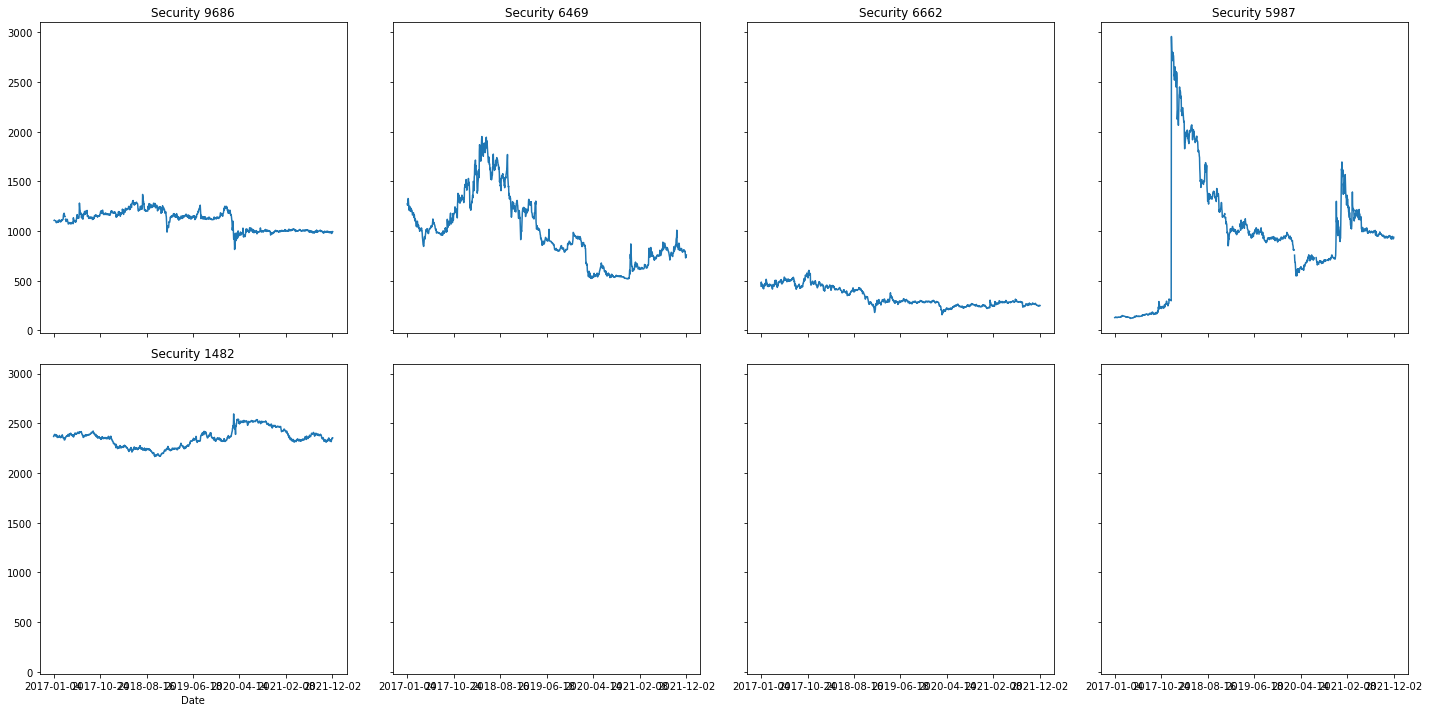

In [4]:
num_plots = len(unique_securities)
num_columns = 4
num_rows = math.ceil(num_plots / num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5), sharex=True, sharey=True)

for index, security_code in enumerate(unique_securities):
    row = index // num_columns
    col = index % num_columns

    security_data = data[data['SecuritiesCode'] == security_code]
    security_data.set_index('Date', inplace=True)

    # Plot the closing prices 
    security_data['Close'].plot(ax=axes[row, col])
    axes[row, col].set_title(f'Security {security_code}')

plt.tight_layout()
plt.show()

In [5]:
df = security_data

In [6]:
import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED=42
seed_everything(SEED)
df = df.reset_index()
df = df.drop(columns=['RowId', 'ExpectedDividend', 'AdjustmentFactor', 'SupervisionFlag']).dropna()

df.head(3)

,Date,SecuritiesCode,Open,High,Low,Close,Volume,Target
0,2017-01-04,1482,2372.0,2372.0,2359.0,2368.0,1521,0.002946
1,2017-01-05,1482,2378.0,2383.0,2364.0,2376.0,1751,0.000000
2,2017-01-06,1482,2369.0,2383.0,2369.0,2383.0,5052,0.000420


I decide to drop 'RowId', 'ExpectedDividend', 'AdjustmentFactor', 'SupervisionFlag' not needed

In [7]:
#Checking for any null values and removing the null values
print('Null Values =',df.isnull().values.any())
print('NA Values =',df.isna().values.any())

Null Values = False
NA Values = False


# Data enrichment

Let's add indicators as MMA and RSI


In [8]:
df['Close_5_day_SMA'] = df['Close'].rolling(window=5).mean()

def compute_rsi(df, time_window):
    diff = df.diff(1).dropna()
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[diff > 0]
    down_chg[diff < 0] = diff[diff < 0]
    up_chg_avg = up_chg.rolling(window=time_window).mean()
    down_chg_avg = down_chg.abs().rolling(window=time_window).mean()
    rs = up_chg_avg / down_chg_avg
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_7'] = compute_rsi(df['Close'], 7)

df['Open_Close_interaction'] = df['Open'] * df['Close']

df.head(10)

,Date,SecuritiesCode,Open,High,Low,Close,Volume,Target,Close_5_day_SMA,RSI_7,Open_Close_interaction
0,2017-01-04,1482,2372.0,2372.0,2359.0,2368.0,1521,0.002946,NaN,NaN,5616896.0
1,2017-01-05,1482,2378.0,2383.0,2364.0,2376.0,1751,0.000000,NaN,NaN,5650128.0
2,2017-01-06,1482,2369.0,2383.0,2369.0,2383.0,5052,0.000420,NaN,NaN,5645327.0
3,2017-01-10,1482,2384.0,2388.0,2381.0,2383.0,622,0.002517,NaN,NaN,5681072.0
4,2017-01-11,1482,2383.0,2385.0,2380.0,2384.0,1785,-0.005439,2378.8,NaN,5681072.0
5,2017-01-12,1482,2389.0,2391.0,2386.0,2390.0,3782,0.001683,2383.2,NaN,5709710.0
6,2017-01-13,1482,2382.0,2382.0,2377.0,2377.0,985,-0.001260,2383.4,NaN,5662014.0
7,2017-01-16,1482,2381.0,2382.0,2372.0,2381.0,2219,0.002944,2383.0,66.666667,5669161.0
8,2017-01-17,1482,2378.0,2380.0,2372.0,2378.0,179,-0.004612,2382.0,52.941176,5654884.0
9,2017-01-18,1482,2362.0,2386.0,2362.0,2385.0,1330,-0.001685,2382.2,52.941176,5633370.0


7-day RSI, should be more sensitive to price changes, making it faster to react to market movements. This can be beneficial for shorter-term strategies for instance

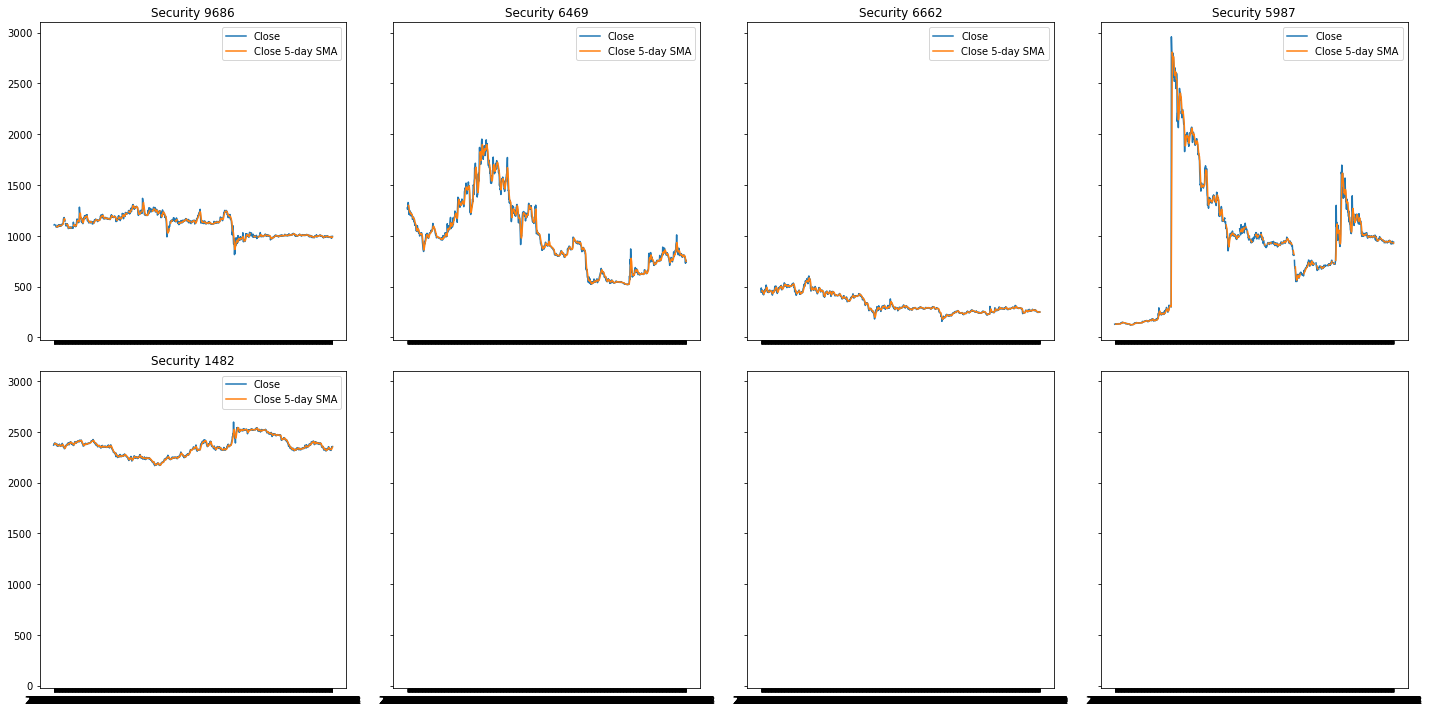

In [9]:
num_plots = len(unique_securities)
num_columns = 4
num_rows = math.ceil(num_plots / num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5), sharex=True, sharey=True)

for index, security_code in enumerate(unique_securities):
    row = index // num_columns
    col = index % num_columns

    security_data = data[data['SecuritiesCode'] == security_code]
    security_data.set_index('Date', inplace=True)

    # Calculate the 5-day simple moving average of the closing prices
    security_data['Close_5_day_SMA'] = security_data['Close'].rolling(window=5).mean()

    # Plot the closing prices and 5-day SMA on the specified axis
    axes[row, col].plot(security_data['Close'], label='Close')
    axes[row, col].plot(security_data['Close_5_day_SMA'], label='Close 5-day SMA')
    axes[row, col].set_title(f'Security {security_code}')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

# Time Series

In [10]:
import statsmodels.api as sm

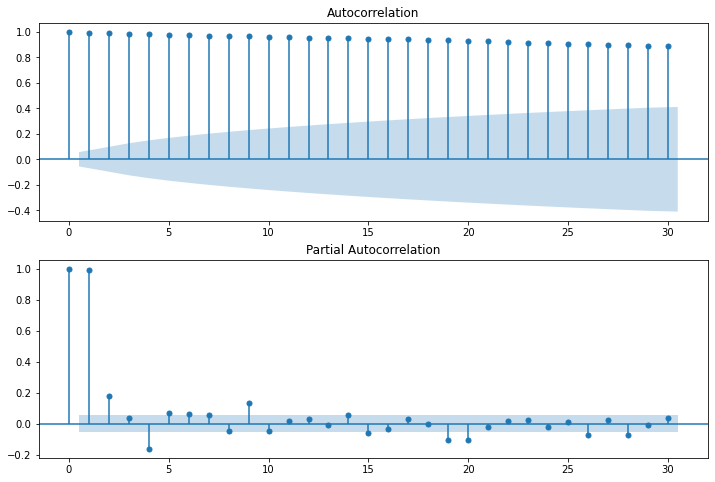

In [11]:
df.set_index('Date', inplace=True)
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(df['Close'], lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['Close'], lags=30, ax=ax[1])
plt.show()

Analyze ACF and PACF plots:

(ACF) and partial autocorrelation function (PACF) of time series data to get an initial idea of the p and q parameters.

A sharp drop in ACF after a certain lag suggests the value of q.

A sharp drop in PACF after a certain lag suggests the value of p.
*Keep in mind that here the result is linked to the randomness of the code here it sugest an AR(2)due to the sharp drop in PACF lag 2*

In [12]:
from statsmodels.tsa.stattools import adfuller
def adf_test(time_series):
    result = adfuller(time_series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

adf_test(df['Close'])

ADF Statistic: -1.6004526309984786
p-value: 0.48336609345367304


Determine the order of differencing (d):
Check if the time series is stationary. If not, apply differencing to make it stationary.
Use the Augmented Dickey-Fuller (ADF) test to check for stationarity. If the p-value is less than a chosen significance level (e.g., 0.05), the time series is stationary.

In [13]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Define a range of p, d, and q parameters I kept 0 to 3(2)
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Perform time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Function to evaluate an ARIMA model using cross-validation
def evaluate_arima_model(df, p, d, q):
    mse_scores = []
    for train_index, test_index in tscv.split(df):
        train_cv, test_cv = df.iloc[train_index], df.iloc[test_index]
        model = ARIMA(train_cv, order=(p, d, q)).fit()
        predictions = model.forecast(steps=len(test_cv))
        mse = mean_squared_error(test_cv, predictions)
        mse_scores.append(mse)
    return np.mean(mse_scores)

# Grid search
best_score, best_order = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                mse = evaluate_arima_model(df['Close'], p, d, q)
                if mse < best_score:
                    best_score, best_order = mse, (p, d, q)
                print(f'ARIMA({p}, {d}, {q}) - MSE: {mse}')
            except:
                continue

print(f'Best ARIMA model: ARIMA{best_order}')

C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Predicti

ARIMA(0, 0, 0) - MSE: 12802.44626599232


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Predicti

ARIMA(0, 0, 1) - MSE: 12756.268433037256


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency in

ARIMA(0, 0, 2) - MSE: 12732.338487961604
ARIMA(0, 1, 0) - MSE: 4033.0490000000004


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency in

ARIMA(0, 1, 1) - MSE: 4032.0589029662797


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Predicti

ARIMA(0, 1, 2) - MSE: 4024.9982552911765


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Predicti

ARIMA(1, 0, 0) - MSE: 5588.093757821213


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency in

ARIMA(1, 0, 1) - MSE: 5360.305773262053


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency in

ARIMA(1, 0, 2) - MSE: 5193.5574459170575
ARIMA(1, 1, 0) - MSE: 4027.642354134246


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Predicti

ARIMA(1, 1, 1) - MSE: 4028.7210003593327


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Predicti

ARIMA(1, 1, 2) - MSE: 4853.306430363052


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency in

ARIMA(2, 0, 0) - MSE: 5256.067515040765


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Predicti

ARIMA(2, 0, 1) - MSE: 5308.812552564587


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency in

ARIMA(2, 0, 2) - MSE: 5571.903615002943


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency in

ARIMA(2, 1, 0) - MSE: 4030.483855755556


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency in

ARIMA(2, 1, 1) - MSE: 4036.9784151554913


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency in

ARIMA(2, 1, 2) - MSE: 4848.200887334888
Best ARIMA model: ARIMA(0, 1, 2)


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Data prep Train_data and Test_data
# Basic sheme I split the data into training and testing sets 80% and 20%
train_data = df.sample(frac=0.8, random_state=42)
test_data = df.drop(train_data.index)

# To get it works I had to DateTimeIndex
train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)

# Same here
train_data = train_data.dropna(subset=['Close_5_day_SMA', 'RSI_7'])
test_data = test_data.dropna(subset=['Close_5_day_SMA', 'RSI_7'])

# Define the order (p, d, q) from the ARIMA model
order = (0, 1, 2)
seasonal_order = (0, 1, 2, 12)  


# Fit the SARIMAX model
exog_vars = train_data[['Close_5_day_SMA', 'RSI_7']]
sarimax_model = SARIMAX(train_data['Close'], order=order, seasonal_order=seasonal_order, exog=exog_vars).fit()
exog_test = test_data[['Close_5_day_SMA', 'RSI_7']]
n_train = len(train_data)
n_test = len(test_data)
pred_obj = sarimax_model.get_prediction(start=n_train, end=n_train + n_test - 1, exog=exog_test)
predictions = pred_obj.predicted_mean

print(predictions)

C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so w

955     2379.941459
956     2376.452773
957     2370.714795
958     2354.379737
959     2357.652657
           ...     
1189    2312.306928
1190    2348.285108
1191    2321.374535
1192    2323.079192
1193    2341.581454
Name: predicted_mean, Length: 239, dtype: float64


C:\Users\Riviere\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


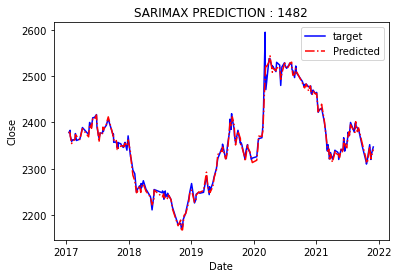

In [23]:
#Plot the predictions of the test_data
plt.plot(test_data.index, test_data['Close'], label='target', color='blue')
plt.plot(test_data.index, predictions, label='Predicted', color='red', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('SARIMAX PREDICTION : 1482')
plt.legend()
plt.show()